In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distlibert/pytorch/default/1/distilbert-model/config.json
/kaggle/input/distlibert/pytorch/default/1/distilbert-model/model.safetensors
/kaggle/input/distlibert/pytorch/default/1/distilbert-tokenizer/tokenizer.json
/kaggle/input/distlibert/pytorch/default/1/distilbert-tokenizer/tokenizer_config.json
/kaggle/input/distlibert/pytorch/default/1/distilbert-tokenizer/special_tokens_map.json
/kaggle/input/distlibert/pytorch/default/1/distilbert-tokenizer/vocab.txt
/kaggle/input/roberta-base2/pytorch/default/1/roberta-tokenizer/merges.txt
/kaggle/input/roberta-base2/pytorch/default/1/roberta-tokenizer/tokenizer.json
/kaggle/input/roberta-base2/pytorch/default/1/roberta-tokenizer/vocab.json
/kaggle/input/roberta-base2/pytorch/default/1/roberta-tokenizer/tokenizer_config.json
/kaggle/input/roberta-base2/pytorch/default/1/roberta-tokenizer/special_tokens_map.json
/kaggle/input/roberta-base2/pytorch/default/1/roberta-mode/config.json
/kaggle/input/roberta-base2/pytorch/default/1/rob

In [3]:
import os
print("Checking model directory contents:")
model_path = '/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2'
tokenizer_path = '/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-tokenizer2'

print("\nModel directory contents:")
print(os.listdir(model_path) if os.path.exists(model_path) else "Directory not found")

print("\nTokenizer directory contents:")
print(os.listdir(tokenizer_path) if os.path.exists(tokenizer_path) else "Directory not found")

Checking model directory contents:

Model directory contents:
['config.json', 'tf_model.h5']

Tokenizer directory contents:
['merges.txt', 'tokenizer.json', 'vocab.json', 'tokenizer_config.json', 'special_tokens_map.json']


# Gather data, determine the method of data collection and provenance of the data (1 point)
- This project will create a model using Natural Language Processing (NLP) by participating in a Kaggle competition https://www.kaggle.com/competitions/tweet-sentiment-extraction.

# 2. Identify a Deep Learning Problem (5 points)
- With tweets circulating every second, it's challenging to determine whether a sentiment will positively boost a brand or harm it with a negative tone. In this competition, I'll identify the words or phrases that convey the sentiment in a tweet. Using a rich dataset from Figure Eight's Data for Everyone platform, labeled with sentiments under the Creative Commons Attribution 4.0 license, This project's goal is to build a model that identifies the specific language supporting each sentiment.

### Evaluation
The competition uses the word-level Jaccard score as the metric. For a helpful explanation of Jaccard similarity for strings, see this overview. A Python implementation is provided:  
def jaccard(str1, str2):  
    a = set(str1.lower().split())  
    b = set(str2.lower().split())  
    c = a.intersection(b)  
    return float(len(c)) / (len(a) + len(b) - len(c))  


### Submission File
For each ID in the test set, predict the text that best reflects the sentiment. The selected text must be quoted and complete (including punctuation) to match the metric’s requirements. The submission file should have this format:
textID,selected_text
2,"very good"
5,"I don't care"
6,"bad"
8,"it was, yes"
...
s" etc.

In [4]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the data
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

# 3. Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)
# 3.1. data description
## 3.1.1 Training Data (train.csv)
- Size: 27,481 rows, 4 columns
- Columns: textID, text, selected_text, sentiment
- Missing Values:
  - text: 1 missing entry
  - selected_text: 1 missing entry
- Sentiment Distribution:
  - Neutral: 11,118 entries
  - Positive: 8,582 entries
  - Negative: 7,781 entries
- Text Length:
  - Average Length: ~12.9 words
  - Median Length: 12 words

## 3.1.2 Test Data (test.csv)
- Size: 3,534 rows, 3 columns
- Columns: textID, text, sentiment
- Missing Values: None
- Text Length:
  - Average Length: ~12.8 words
  - Median Length: 12 words

In [5]:
# Check the first few rows of the training data
print("First 5 rows of the training data:")
print(train_df.head())

# Basic information about the training data
print("\nTraining data info:")
print(train_df.info())

# 2.1 Training Data (train.csv)
print("Training Data (train.csv)")

# Size and columns
print(f"Size: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print("Columns:", list(train_df.columns))

# Missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Sentiment Distribution
print("\nSentiment Distribution:")
print(train_df['sentiment'].value_counts())

# Text Length (in words)
train_df['text'] = train_df['text'].fillna('')  # Fill missing values
train_df['text_word_count'] = train_df['text'].apply(lambda x: len(x.split()))
print("\nText Length (in words):")
print(f"Average Length: {train_df['text_word_count'].mean():.1f} words")
print(f"Median Length: {train_df['text_word_count'].median()} words")

# 2.2 Test Data (test.csv)
print("\nTest Data (test.csv)")

# Size and columns
print(f"Size: {test_df.shape[0]} rows, {test_df.shape[1]} columns")
print("Columns:", list(test_df.columns))

# Missing values
print("\nMissing Values:")
print(test_df.isnull().sum())

# Text Length (in words)
test_df['text'] = test_df['text'].fillna('')  # Fill missing values if any
test_df['text_word_count'] = test_df['text'].apply(lambda x: len(x.split()))
print("\nText Length (in words):")
print(f"Average Length: {test_df['text_word_count'].mean():.1f} words")
print(f"Median Length: {test_df['text_word_count'].median()} words")




First 5 rows of the training data:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null 

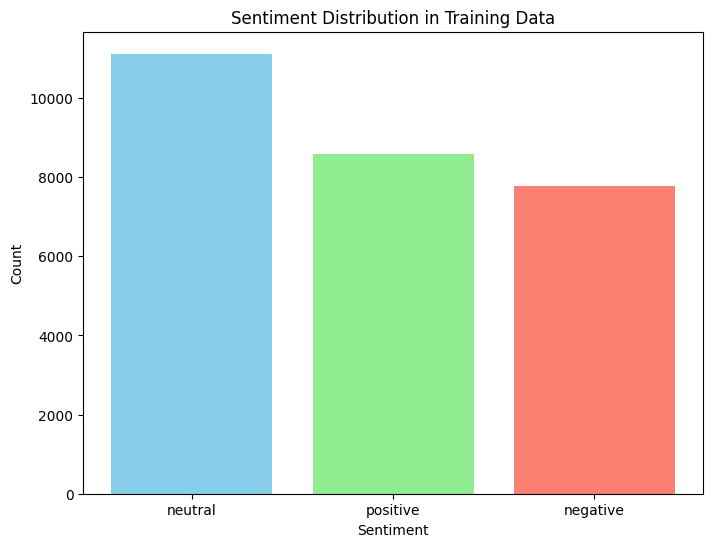

In [6]:
# Basic overview of the train and test datasets
train_info = {
    "Number of rows": train_df.shape[0],
    "Number of columns": train_df.shape[1],
    "Columns": train_df.columns.tolist(),
    "Missing values": train_df.isnull().sum().to_dict(),
    "Sentiment distribution": train_df['sentiment'].value_counts().to_dict(),
    "Average text length (train)": train_df['text'].str.split().str.len().mean(),
    "Median text length (train)": train_df['text'].str.split().str.len().median(),
}

test_info = {
    "Number of rows": test_df.shape[0],
    "Number of columns": test_df.shape[1],
    "Columns": test_df.columns.tolist(),
    "Missing values": test_df.isnull().sum().to_dict(),
    "Average text length (test)": test_df['text'].str.split().str.len().mean(),
    "Median text length (test)": test_df['text'].str.split().str.len().median(),
}

# Display the information
train_info, test_info

# Load lib
import matplotlib.pyplot as plt

# Sentiment distribution
sentiment_counts = train_df['sentiment'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Sentiment Distribution in Training Data")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


## 3.2. Exploratory Data Analysis (EDA)

### 3.2.1. Sentiment Distribution
A bar chart showing the distribution of sentiment labels.

### 3.2.2. Tweet Length Analysis
A histogram showing tweet lengths (in words) for each sentiment category.

### 3.2.3. Word Frequency Analysis
Word clouds show the most common words by sentiment after removing stop words.

### 3.2.4. Bi-gram Analysis
Shows common bi-grams (two-word phrases) in positive tweets.

This EDA helps me understand tweet characteristics, which can inform preprocessing and model-building steps, such as handling class imbalance or using bi-grams for feature engineering.

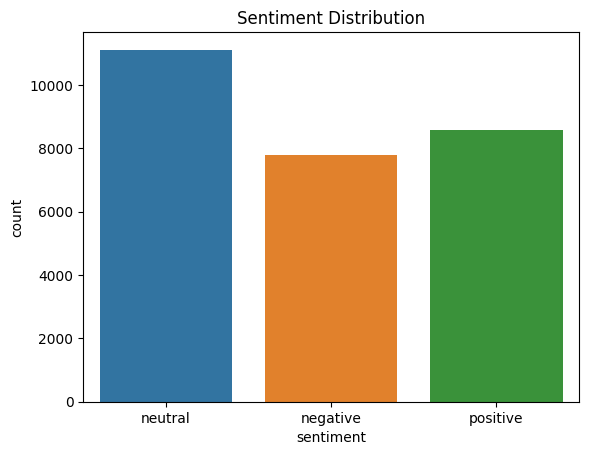

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

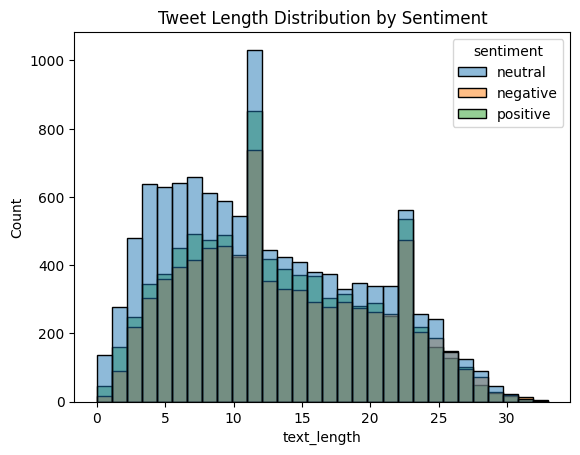

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


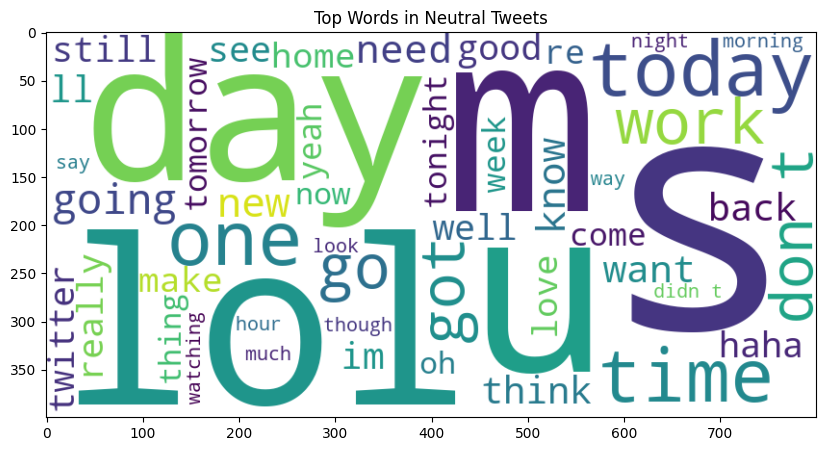

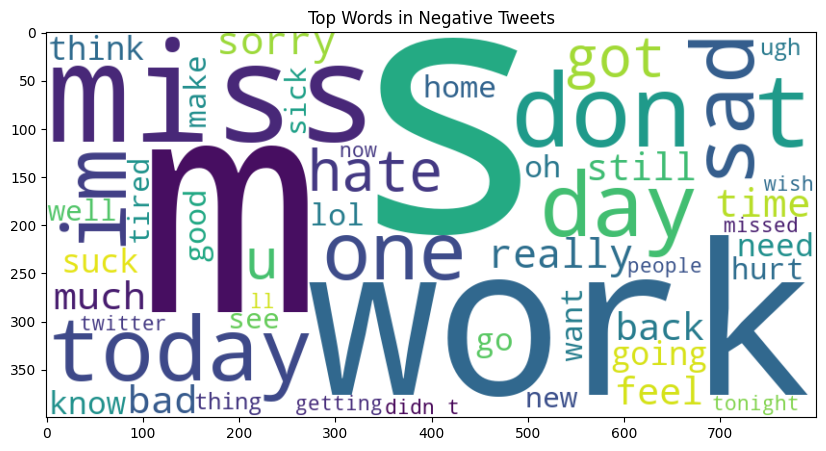

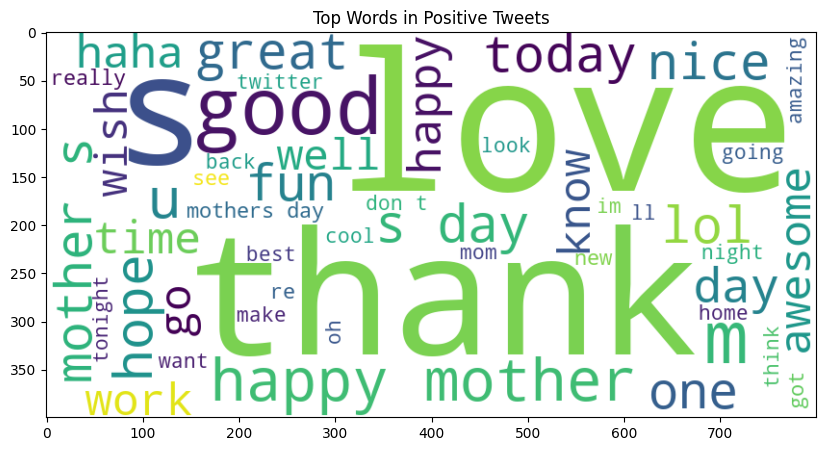

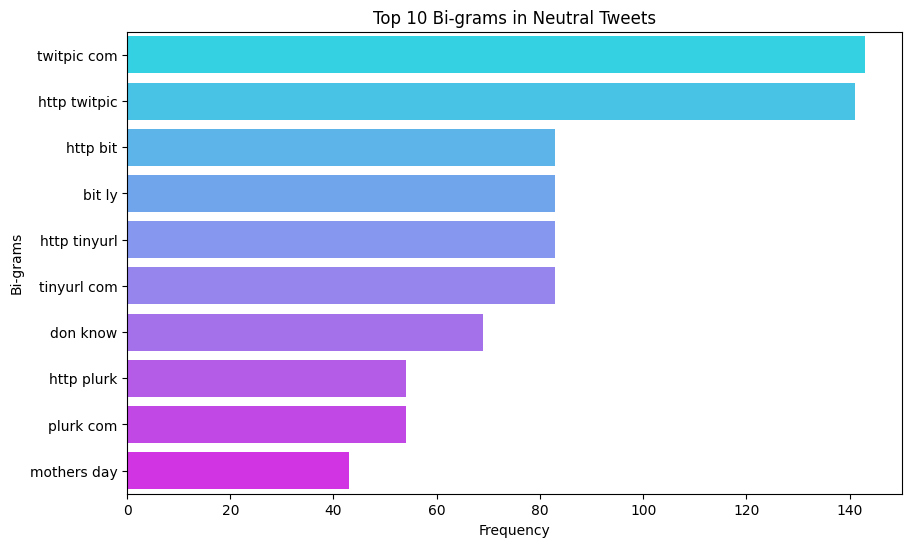

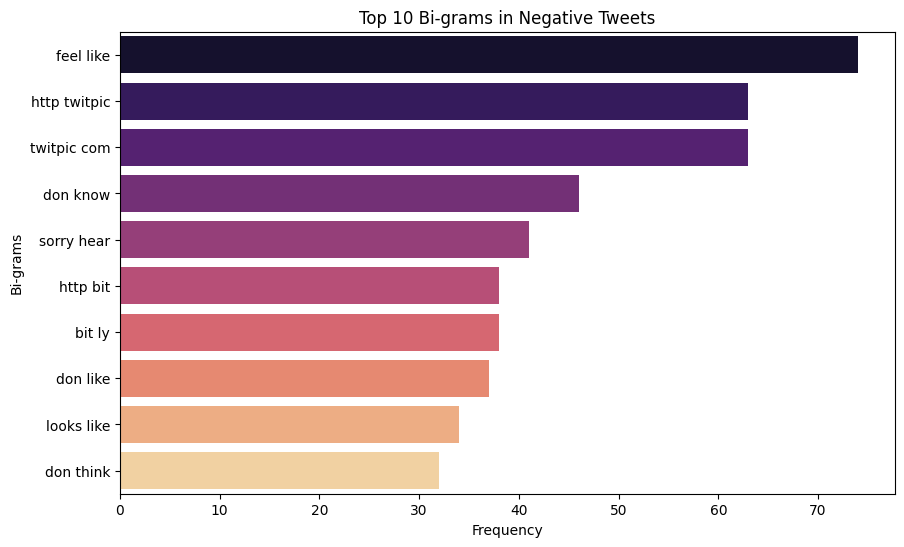

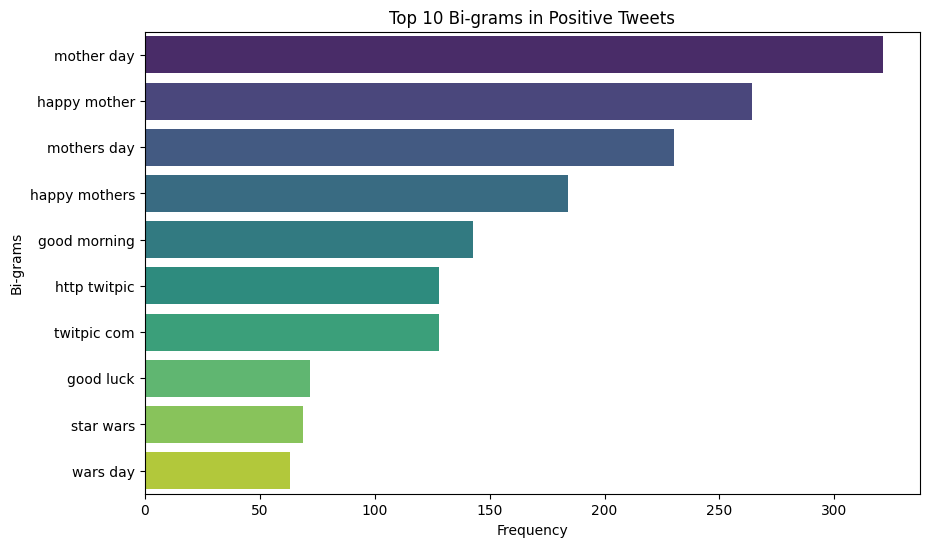

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# Load data
# 'train_df' is already loaded

# 1. Distribution of Sentiment Labels
sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution')
plt.show()

# 2. Text Length Analysis
train_df['text_length'] = train_df['text'].str.split().str.len()
sns.histplot(data=train_df, x='text_length', hue='sentiment', bins=30)
plt.title('Tweet Length Distribution by Sentiment')
plt.show()

# 3. Word Frequency Analysis
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
train_df['clean_text'] = train_df['text'].apply(lambda x: ' '.join([word for word in str(x).lower().split() if word not in stop_words]))

# Top words for each sentiment
for sentiment in train_df['sentiment'].unique():
    words = ' '.join(train_df[train_df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('on')
    plt.title(f'Top Words in {sentiment.capitalize()} Tweets')
    plt.show()



# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(2,2), n=10):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]



# 4. Common Bi-grams in Neutral Tweets
neutral_texts = train_df[train_df['sentiment'] == 'neutral']['clean_text']
top_neutral_bigrams = get_top_ngrams(neutral_texts, ngram_range=(2,2))

# Convert bi-grams to DataFrame for plotting
bigrams_df_neu = pd.DataFrame(top_neutral_bigrams, columns=['Bigram', 'Frequency'])

# Plot the bi-gram frequencies as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=bigrams_df_neu, x='Frequency', y='Bigram', palette='cool')
plt.title('Top 10 Bi-grams in Neutral Tweets')
plt.xlabel('Frequency')
plt.ylabel('Bi-grams')
plt.show()


# 5. Common Bi-grams in Negative Tweets
negative_texts = train_df[train_df['sentiment'] == 'negative']['clean_text']
top_negative_bigrams = get_top_ngrams(negative_texts, ngram_range=(2,2))

# Convert bi-grams to DataFrame for plotting
bigrams_df_neg = pd.DataFrame(top_negative_bigrams, columns=['Bigram', 'Frequency'])

# Plot the bi-gram frequencies as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=bigrams_df_neg, x='Frequency', y='Bigram', palette='magma')
plt.title('Top 10 Bi-grams in Negative Tweets')
plt.xlabel('Frequency')
plt.ylabel('Bi-grams')
plt.show()


# 6. Common Bi-grams in Positive Tweets
positive_texts = train_df[train_df['sentiment'] == 'positive']['clean_text']
top_positive_bigrams = get_top_ngrams(positive_texts, ngram_range=(2,2))

# Convert bi-grams to DataFrame for plotting
bigrams_df = pd.DataFrame(top_positive_bigrams, columns=['Bigram', 'Frequency'])

# Plot the bi-gram frequencies as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=bigrams_df, x='Frequency', y='Bigram', palette='viridis')
plt.title('Top 10 Bi-grams in Positive Tweets')
plt.xlabel('Frequency')
plt.ylabel('Bi-grams')
plt.show()

# 4. Base Model (BERT Model)
## 4.1 Training the BERT model and extracting results from the test data
irst, I used the BERT model as the base model and trained it to extract words that express sentiment from the text in train.csv. I then used this trained model to extract words that express sentiment from the text in test.csv.

In [8]:
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

def jaccard_similarity(str1, str2):
    """
    Calculate Jaccard similarity between two strings
    """
    # Convert strings to sets of words
    str1 = set(str1.lower().split())
    str2 = set(str2.lower().split())
    
    # Handle empty strings
    if not str1 and not str2:
        return 1.0
    if not str1 or not str2:
        return 0.0
    
    # Calculate Jaccard similarity
    intersection = len(str1.intersection(str2))
    union = len(str1.union(str2))
    return intersection / union if union != 0 else 0

# File paths
train_path = '/kaggle/input/tweet-sentiment-extraction/train.csv'
test_path = '/kaggle/input/tweet-sentiment-extraction/test.csv'
submission_path = '/kaggle/working/submission.csv'

# Check if files exist
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Ensure train and test file paths are correct.")

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Initialize tokenizer and model (using the cased version)
tokenizer = BertTokenizerFast.from_pretrained('/kaggle/input/bert/pytorch/default/1/bert-tokenizer/')
model = BertForTokenClassification.from_pretrained('/kaggle/input/bert/pytorch/default/1/bert-model/', num_labels=2)

# Prepare dataset class
class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128, is_test=False):
        self.dataframe = dataframe.fillna('')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['text'])
        sentiment = str(row['sentiment'])

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        if not self.is_test:
            selected_text = str(row['selected_text'])
            selected_enc = self.tokenizer(selected_text, truncation=True, max_length=self.max_length)
            labels = [0] * len(encoding['input_ids'])

            # Label selected tokens
            selected_ids = selected_enc['input_ids'][1:-1]  # Exclude [CLS] and [SEP] tokens
            for i, token_id in enumerate(encoding['input_ids']):
                if token_id in selected_ids:
                    labels[i] = 1

            encoding['labels'] = labels

        return {key: torch.tensor(val) for key, val in encoding.items()}

# Split the data
train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)
train_dataset = TweetDataset(train_data, tokenizer)
val_dataset = TweetDataset(val_data, tokenizer)
test_dataset = TweetDataset(test_df, tokenizer, is_test=True)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    report_to="none"
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

# Train the model
trainer.train()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediction function with device handling
def predict_selected_text(text, sentiment):
    # Tokenize the input text and move tensors to the correct device
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="pt"
    ).to(device)  # Move encoding tensors to the model's device

    with torch.no_grad():
        # Move model outputs to the same device
        outputs = model(**encoding)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Move tokens and predictions back to CPU for processing
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].cpu())
    selected_tokens = [tokens[i] for i, label in enumerate(predictions[0].cpu()) if label == 1]
    return tokenizer.convert_tokens_to_string(selected_tokens)

# Calculate Jaccard score for validation set
print("Calculating Jaccard scores for validation set...")
jaccard_scores = []
for i, row in tqdm(val_data.iterrows(), total=len(val_data)):
    pred_text = predict_selected_text(row['text'], row['sentiment'])
    jaccard_score = jaccard_similarity(str(row['selected_text']), pred_text)
    jaccard_scores.append(jaccard_score)

print(f"Average Jaccard score on validation set: {np.mean(jaccard_scores):.4f}")

# Generate predictions for test set
print("Generating predictions for test set...")
predictions = []
for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pred_text = predict_selected_text(row['text'], row['sentiment'])
    predictions.append(pred_text)

# Create submission file
submission_df = pd.DataFrame({
    'textID': test_df['textID'],
    'selected_text': predictions
})
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")

# Display first 20 rows of the submission file
print("\nFirst 20 predictions:")
print(submission_df.head(20))

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.087100,0.089244
2,0.075600,0.081978
3,0.062600,0.089844


Calculating Jaccard scores for validation set...


100%|██████████| 2749/2749 [00:29<00:00, 92.86it/s]


Average Jaccard score on validation set: 0.5054
Generating predictions for test set...


100%|██████████| 3534/3534 [00:38<00:00, 92.99it/s]

Submission file saved to /kaggle/working/submission.csv

First 20 predictions:
        textID                                      selected_text
0   f87dea47db  Last session of the day http : / / twit. com /...
1   96d74cb729                                     exciting. Good
2   eee518ae67                                      such a shame!
3   01082688c6                                        happy bday!
4   33987a8ee5                                        I like it!!
5   726e501993                                that ` s great!!!!!
6   261932614e              I THINK EVERYONE HATES ME ON HERE lol
7   afa11da83f                          sooooo completely blocked
8   e64208b4ef  and within a short time of the last clue all o...
9   37bcad24ca  What did you get? My day is alright.. haven ` ...
10  24c92644a4                                    ah total bummer
11  43b390b336                                 I. We didn ` t win
12  69d6b5d93e  .. and you ` re on twitter! Did the tavern bor.

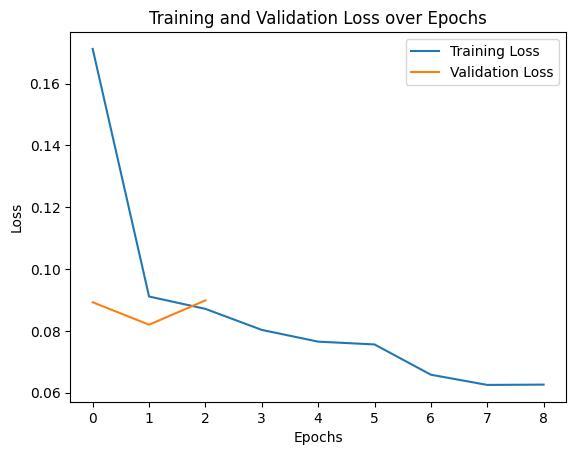

In [9]:
import matplotlib.pyplot as plt

training_loss = trainer.state.log_history  # Assuming `trainer.state.log_history` stores logs
# Extract and plot training and evaluation losses
train_losses = [entry["loss"] for entry in training_loss if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in training_loss if "eval_loss" in entry]

plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

In [13]:
import pandas as pd

# Load the test data and submission file
test_path = '/kaggle/input/tweet-sentiment-extraction/test.csv'
submission_path = '/kaggle/working/submission.csv'

test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Merge test_df and submission_df on "textID"
merged_df = test_df.merge(submission_df, on="textID", how="left")

# Display the first 20 rows of "textID", "text", and "selected_text"
print(merged_df[['textID', 'text', 'selected_text']].head(20))

        textID                                               text  \
0   f87dea47db  Last session of the day  http://twitpic.com/67ezh   
1   96d74cb729   Shanghai is also really exciting (precisely -...   
2   eee518ae67  Recession hit Veronique Branquinho, she has to...   
3   01082688c6                                        happy bday!   
4   33987a8ee5             http://twitpic.com/4w75p - I like it!!   
5   726e501993                    that`s great!! weee!! visitors!   
6   261932614e            I THINK EVERYONE HATES ME ON HERE   lol   
7   afa11da83f   soooooo wish i could, but im in school and my...   
8   e64208b4ef   and within a short time of the last clue all ...   
9   37bcad24ca   What did you get?  My day is alright.. haven`...   
10  24c92644a4  My bike was put on hold...should have known th...   
11  43b390b336                          I checked.  We didn`t win   
12  69d6b5d93e   .. and you`re on twitter! Did the tavern bore...   
13  5c1e0b61a1  I`m in VA for the 

## 4.2 Analysis of the results of the Base Model (BERT Model)
### BERT model's Kaggle Score is 0.50013
The Kaggle score for this BERT model is 0.50013, which is not a very good result.
The table below shows the text from test.csv and the first 20 lines of selected_text. Even looking at these results, I think there is still room for improvement, although selected_text does extract words that indicate a certain degree of emotion.

| Index | textID     | text                                                      | selected_text                                                   |
|-------|------------|-----------------------------------------------------------|------------------------------------------------------------------|
| 0     | f87dea47db | Last session of the day  http://twitpic.com/67ezh         | Last session of the day http : / / twit. com /...               |
| 1     | 96d74cb729 | Shanghai is also really exciting (precisely -...          | exciting. Good                                                  |
| 2     | eee518ae67 | Recession hit Veronique Branquinho, she has to...         | such a shame!                                                   |
| 3     | 01082688c6 | happy bday!                                               | happy bday!                                                     |
| 4     | 33987a8ee5 | http://twitpic.com/4w75p - I like it!!                    | I like it!!                                                     |
| 5     | 726e501993 | that`s great!! weee!! visitors!                           | that ` s great!!!!!                                             |
| 6     | 261932614e | I THINK EVERYONE HATES ME ON HERE   lol                   | I THINK EVERYONE HATES ME ON HERE lol                           |
| 7     | afa11da83f | soooooo wish i could, but im in school and my...          | sooooo completely blocked                                       |
| 8     | e64208b4ef | and within a short time of the last clue all ...          | and within a short time of the last clue all o...               |
| 9     | 37bcad24ca | What did you get?  My day is alright.. haven`t...         | What did you get? My day is alright.. haven ` ...               |
| 10    | 24c92644a4 | My bike was put on hold...should have known th...         | ah total bummer                                                 |
| 11    | 43b390b336 | I checked.  We didn`t win                                 | I. We didn ` t win                                              |
| 12    | 69d6b5d93e | .. and you`re on twitter! Did the tavern bore...          | .. and you ` re on twitter! Did the tavern bor...               |
| 13    | 5c1e0b61a1 | I`m in VA for the weekend, my youngest son tur...         | makes kinda sad,                                                |
| 14    | 504e45d9d9 | Its coming out the socket  I feel like my phon...         | Its coming out the socket I feel like my phone...               |
| 15    | ae93ad52a0 | So hot today =_=  don`t like it and i hate my ...         | i hate bad week                                                 |
| 16    | 9fce30159a | Miss you                                                  | Miss you                                                        |
| 17    | 00d5195223 | Cramps . . .                                              | Cramps...                                                       |
| 18    | 33f19050cf | you guys didn`t say hi or answer my questions...          | nice songs                                                      |
| 19    | f7718b3c23 | I`m going into a spiritual stagnentation, its ...         | I ` m going into a spiritual stagnentation, it...               |
t...               |


# 5. Improve Model (RoBERTa)
Key improvements from the previous BERT model implementation:


### 5.1.1 Model Architecture:


- Switched from BERT to RoBERTa which might performed better custom QA heads for - start/end token prediction
- Implemented proper token offset mapping


### 5.1.2 Training Strategy:


- Implemented 5-fold cross-validation proper handling of sentiment tokens
- Improved text preprocessing with space handling
- Added model checkpointing to save best weights


### 5.1.3 Data Processing:


- Added proper handling of token offsets for selected text
- Improved tokenization with space prefixing
- Better handling of start/end token labeling


### 5.1.4 Prediction Process:


- Implemented ensemble predictions across folds
- Added proper handling of invalid start/end positions
- Improved text extraction from predictions

### 5.1.5 Training Visualization:

- Loss curves
- Fold performance
- Distribution analysis
- Performance summary


### 5.1.6 Prediction Analysis:

- Text length analysis
- Sentiment distribution
- Jaccard score analysis
- Detailed statistics


### 5.1.7 Helper Functions:

- Text span prediction
- Jaccard similarity calculation
- Data processing

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
Training fold 1/5


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Training fold 1
Epoch 1/3
687/687 [==============================] - 342s 410ms/step - loss: 2.1393 - activation_32_loss: 1.0411 - activation_33_loss: 1.0982 - val_loss: 1.7384 - val_activation_32_loss: 0.8870 - val_activation_33_loss: 0.8514
Epoch 2/3
687/687 [==============================] - 268s 390ms/step - loss: 1.7094 - activation_32_loss: 0.8577 - activation_33_loss: 0.8517 - val_loss: 1.6932 - val_activation_32_loss: 0.8690 - val_activation_33_loss: 0.8242
Epoch 3/3
687/687 [==============================] - 268s 390ms/step - loss: 1.5693 - activation_32_loss: 0.8045 - activation_33_loss: 0.7648 - val_loss: 1.6733 - val_activation_32_loss: 0.8624 - val_activation_33_loss: 0.8109
Predicting validation...


Calculating validation Jaccard: 100%|██████████| 5497/5497 [00:01<00:00, 3506.73it/s]


Fold 1 Jaccard Score: 0.7030
Predicting test...
Training fold 2/5


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Training fold 2
Epoch 1/3
688/688 [==============================] - 355s 426ms/step - loss: 2.1442 - activation_34_loss: 1.0714 - activation_35_loss: 1.0729 - val_loss: 1.6291 - val_activation_34_loss: 0.8426 - val_activation_35_loss: 0.7865
Epoch 2/3
688/688 [==============================] - 279s 405ms/step - loss: 1.6567 - activation_34_loss: 0.8529 - activation_35_loss: 0.8039 - val_loss: 1.6489 - val_activation_34_loss: 0.8606 - val_activation_35_loss: 0.7883
Epoch 3/3
688/688 [==============================] - 280s 407ms/step - loss: 1.5014 - activation_34_loss: 0.7774 - activation_35_loss: 0.7240 - val_loss: 1.6283 - val_activation_34_loss: 0.8476 - val_activation_35_loss: 0.7807
Predicting validation...


Calculating validation Jaccard: 100%|██████████| 5496/5496 [00:01<00:00, 3785.21it/s]


Fold 2 Jaccard Score: 0.7033
Predicting test...
Training fold 3/5


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Training fold 3
Epoch 1/3
688/688 [==============================] - 355s 426ms/step - loss: 2.2159 - activation_36_loss: 1.0874 - activation_37_loss: 1.1285 - val_loss: 1.9016 - val_activation_36_loss: 0.9330 - val_activation_37_loss: 0.9687
Epoch 2/3
688/688 [==============================] - 279s 405ms/step - loss: 1.7480 - activation_36_loss: 0.8723 - activation_37_loss: 0.8757 - val_loss: 1.7514 - val_activation_36_loss: 0.8658 - val_activation_37_loss: 0.8855
Epoch 3/3
688/688 [==============================] - 279s 406ms/step - loss: 1.6042 - activation_36_loss: 0.8136 - activation_37_loss: 0.7906 - val_loss: 1.6160 - val_activation_36_loss: 0.8378 - val_activation_37_loss: 0.7783
Predicting validation...


Calculating validation Jaccard: 100%|██████████| 5496/5496 [00:01<00:00, 3672.15it/s]


Fold 3 Jaccard Score: 0.7025
Predicting test...
Training fold 4/5


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Training fold 4
Epoch 1/3
688/688 [==============================] - 351s 425ms/step - loss: 2.1750 - activation_38_loss: 1.0643 - activation_39_loss: 1.1108 - val_loss: 1.6805 - val_activation_38_loss: 0.8507 - val_activation_39_loss: 0.8297
Epoch 2/3
688/688 [==============================] - 297s 432ms/step - loss: 1.6571 - activation_38_loss: 0.8552 - activation_39_loss: 0.8020 - val_loss: 1.6041 - val_activation_38_loss: 0.8197 - val_activation_39_loss: 0.7844
Epoch 3/3
688/688 [==============================] - 278s 405ms/step - loss: 1.5013 - activation_38_loss: 0.7797 - activation_39_loss: 0.7216 - val_loss: 1.6151 - val_activation_38_loss: 0.8207 - val_activation_39_loss: 0.7944
Predicting validation...


Calculating validation Jaccard: 100%|██████████| 5496/5496 [00:01<00:00, 3847.35it/s]


Fold 4 Jaccard Score: 0.6973
Predicting test...
Training fold 5/5


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Training fold 5
Epoch 1/3
688/688 [==============================] - 363s 427ms/step - loss: 2.1618 - activation_40_loss: 1.0596 - activation_41_loss: 1.1022 - val_loss: 1.6276 - val_activation_40_loss: 0.8494 - val_activation_41_loss: 0.7782
Epoch 2/3
688/688 [==============================] - 280s 407ms/step - loss: 1.6413 - activation_40_loss: 0.8449 - activation_41_loss: 0.7965 - val_loss: 1.5959 - val_activation_40_loss: 0.8272 - val_activation_41_loss: 0.7687
Epoch 3/3
688/688 [==============================] - 279s 405ms/step - loss: 1.4962 - activation_40_loss: 0.7716 - activation_41_loss: 0.7246 - val_loss: 1.6027 - val_activation_40_loss: 0.8342 - val_activation_41_loss: 0.7685
Predicting validation...


Calculating validation Jaccard: 100%|██████████| 5496/5496 [00:01<00:00, 3764.83it/s]


Fold 5 Jaccard Score: 0.7077
Predicting test...

Generating training visualizations...


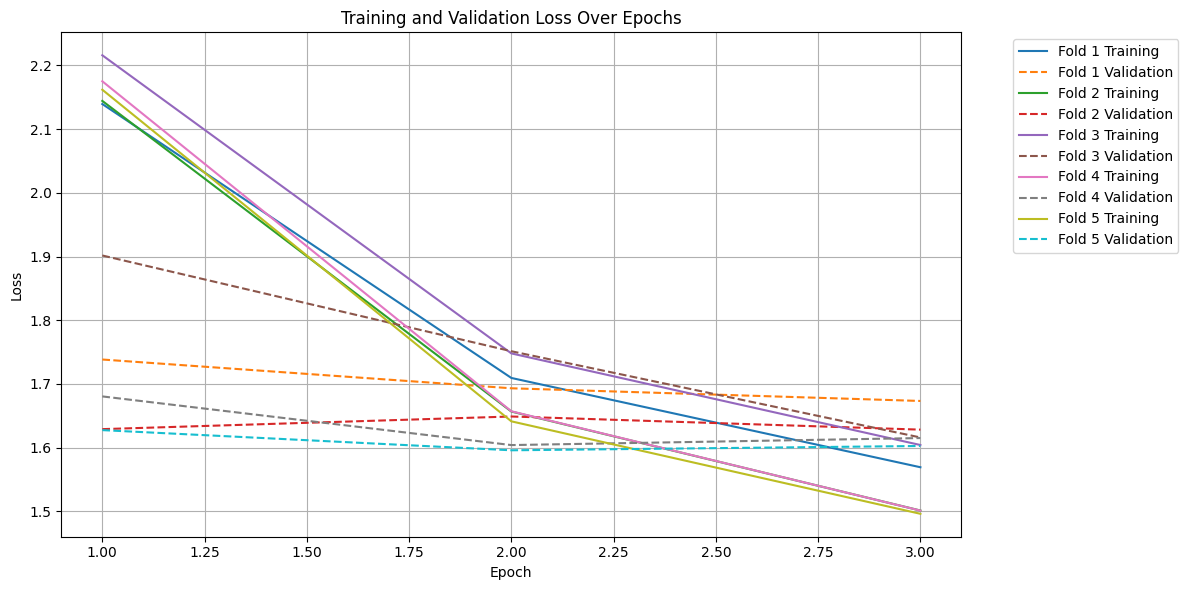

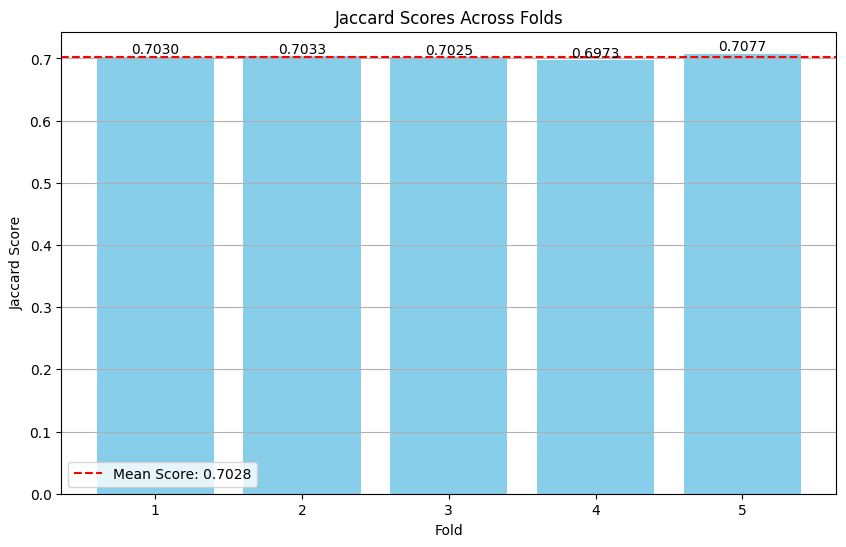

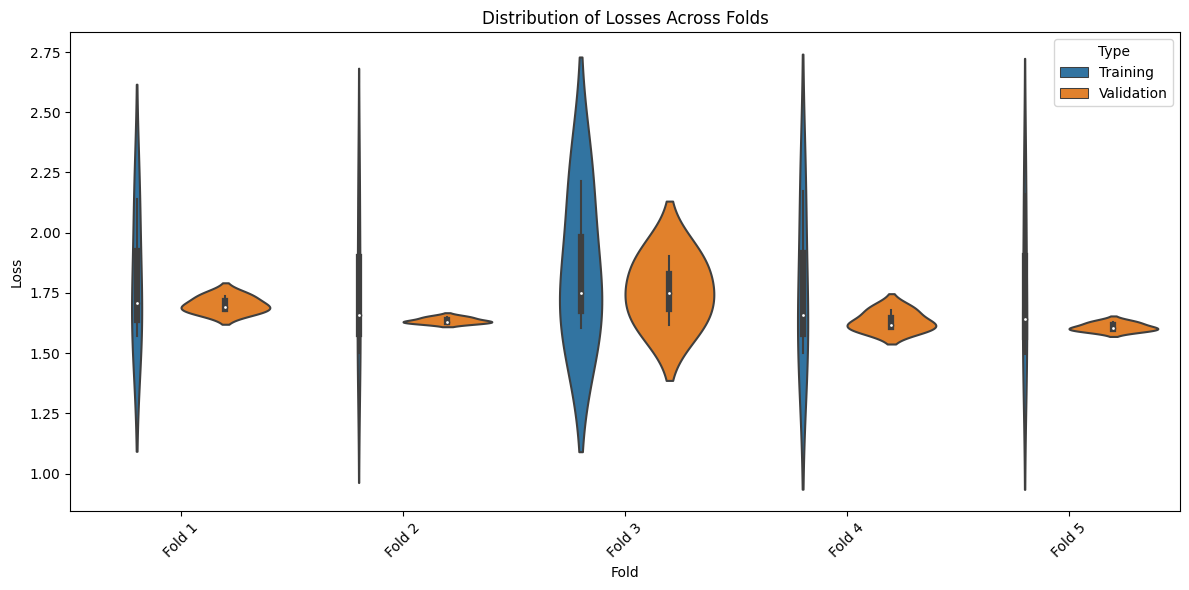

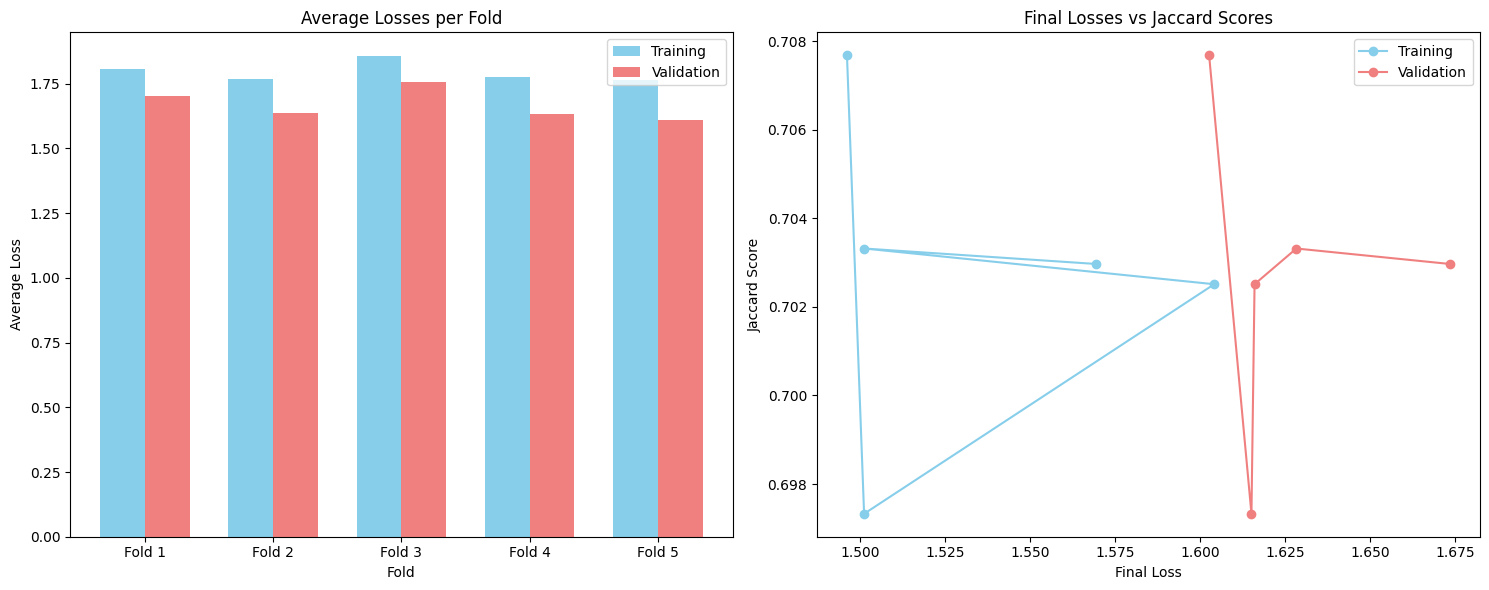


Generating final predictions...


Generating predictions: 100%|██████████| 3534/3534 [00:00<00:00, 4777.71it/s]



Analyzing predictions...


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

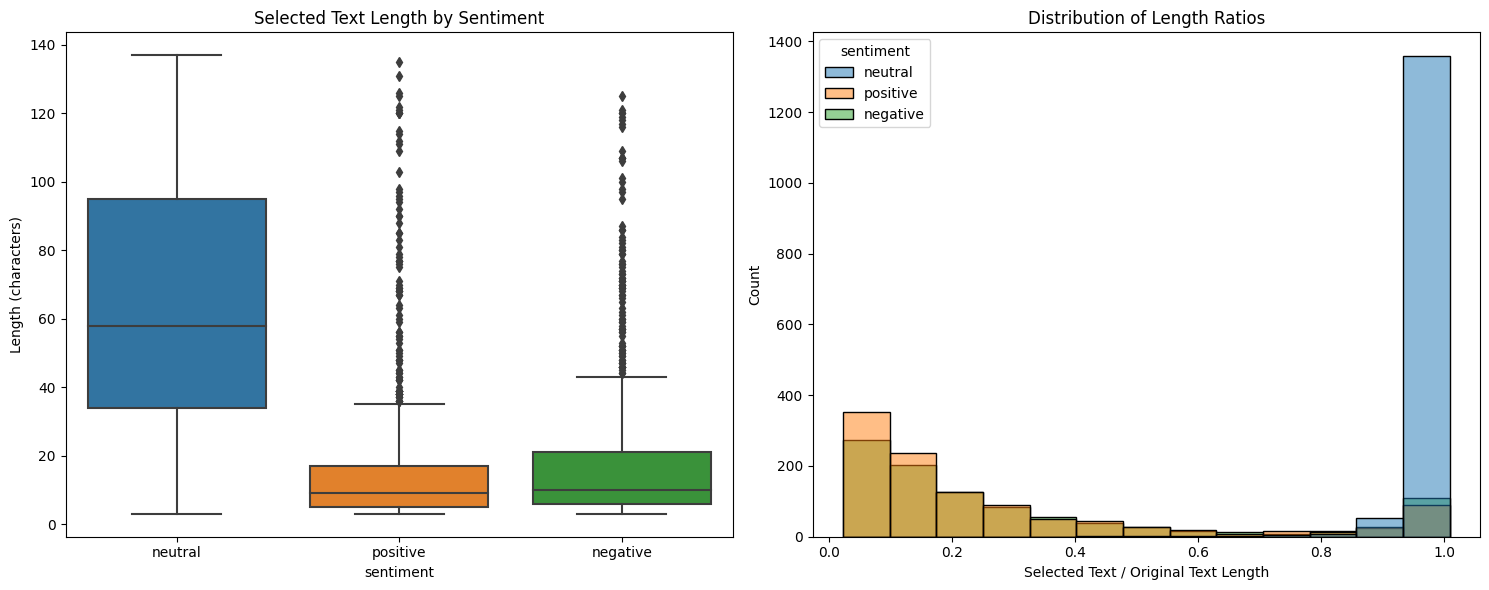

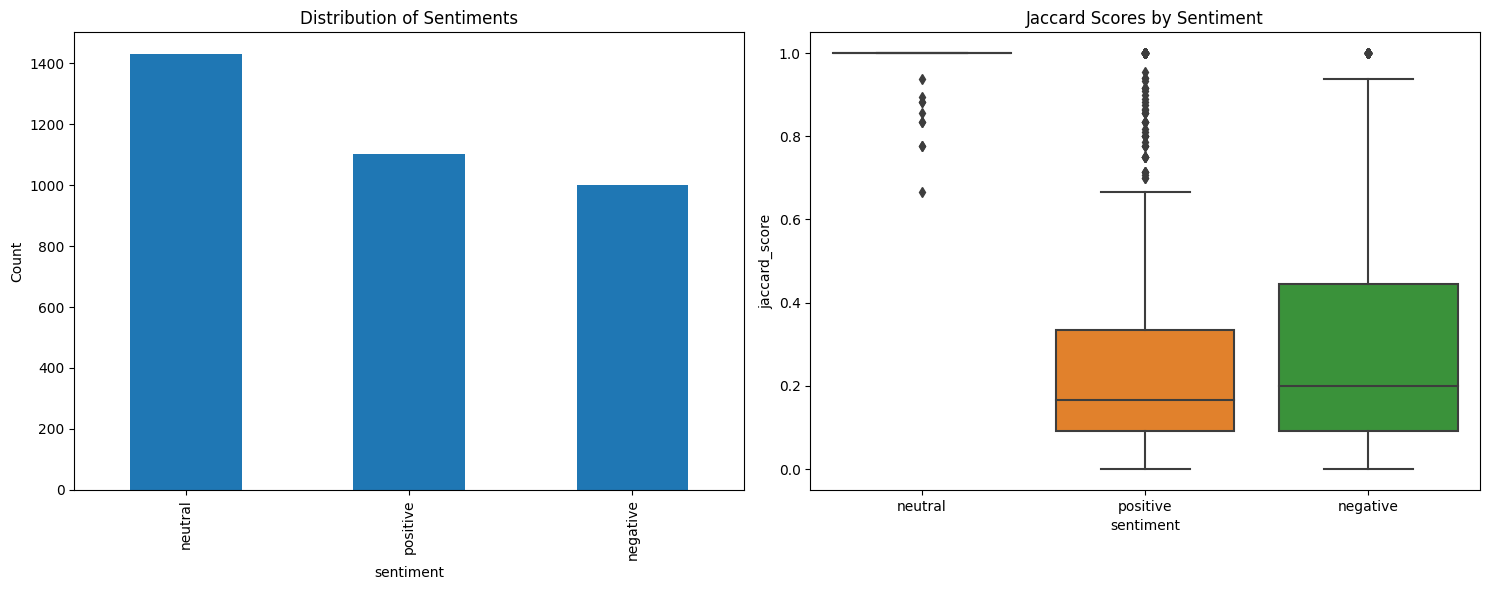

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

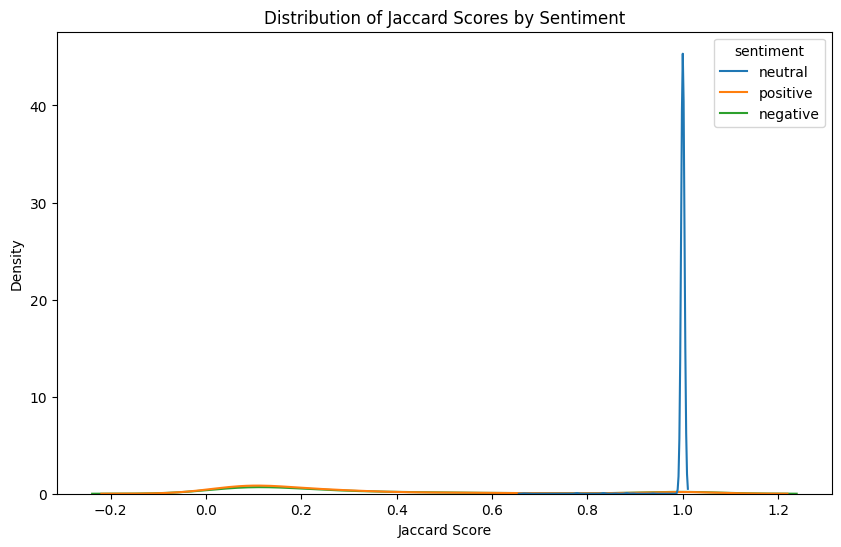


Summary Statistics:
--------------------------------------------------

Sentiment Distribution:
neutral: 1430 (40.5%)
positive: 1103 (31.2%)
negative: 1001 (28.3%)

Jaccard Score Statistics by Sentiment:
            mean    std    min  max
sentiment                          
negative   0.326  0.317  0.000  1.0
neutral    0.999  0.015  0.667  1.0
positive   0.294  0.297  0.000  1.0

Text Length Statistics by Sentiment:
           mean   std  min  max
sentiment                      
negative   18.1  20.5    3  125
neutral    64.7  36.5    3  137
positive   15.5  19.3    3  135

Complete! Check the generated visualizations and submission.csv


In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizerFast, RobertaConfig, TFRobertaModel
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import os
from collections import Counter

# Download NLTK data
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Constants
MAX_LEN = 96
EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 3e-5
N_SPLITS = 5

def jaccard_similarity(str1, str2): 
    """Calculate Jaccard similarity between two strings"""
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

class TweetDataProcessor:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def prepare_data(self, df, is_training=True):
        """Prepare data arrays for training or inference"""
        ct = len(df)
        input_ids = np.ones((ct, MAX_LEN), dtype='int32')
        attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
        token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32')
        
        if is_training:
            start_tokens = np.zeros((ct, MAX_LEN), dtype='int32')
            end_tokens = np.zeros((ct, MAX_LEN), dtype='int32')
        
        for i, row in df.iterrows():
            # Process text
            text = " " + " ".join(row['text'].split())
            
            # Use batch_encode_plus
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=MAX_LEN,
                padding='max_length',
                truncation=True,
                return_token_type_ids=True,
                return_attention_mask=True,
                return_offsets_mapping=True,
                return_tensors='np'
            )
            
            k = i - df.index[0]  # Get relative position in array
            
            if is_training:
                # Find overlap for training data
                selected_text = " ".join(row['selected_text'].split())
                idx = text.find(selected_text)
                chars = np.zeros(len(text))
                chars[idx:idx+len(selected_text)] = 1
                if idx > 0 and text[idx-1] == ' ': 
                    chars[idx-1] = 1
                
                # Get token positions using offset mapping
                toks = []
                offset_mapping = encoding['offset_mapping'][0]
                
                for i, (start, end) in enumerate(offset_mapping):
                    if start < len(chars) and end <= len(chars):
                        if np.sum(chars[start:end]) > 0:
                            toks.append(i)
                
                if len(toks) > 0:
                    start_tokens[k, toks[0]] = 1
                    end_tokens[k, toks[-1]] = 1
            
            # Prepare input arrays
            sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
            s_tok = sentiment_id[row['sentiment']]
            
            input_ids[k, :] = encoding['input_ids'][0]
            attention_mask[k, :] = encoding['attention_mask'][0]
            token_type_ids[k, :] = encoding['token_type_ids'][0]
            
            # Add sentiment token
            try:
                sep_positions = np.where(input_ids[k] == self.tokenizer.sep_token_id)[0]
                if len(sep_positions) > 0:
                    sent_pos = sep_positions[0]
                    if sent_pos + 1 < MAX_LEN:
                        input_ids[k, sent_pos+1] = s_tok
                        attention_mask[k, sent_pos+1] = 1
            except Exception as e:
                print(f"Error processing index {i}: {e}")
            
        if is_training:
            return [input_ids, attention_mask, token_type_ids], [start_tokens, end_tokens]
        return [input_ids, attention_mask, token_type_ids]

def build_model():
    """Build RoBERTa model with QA head"""
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained('/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2')
    bert_model = TFRobertaModel.from_pretrained('/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-mode2', config=config)
    x = bert_model(ids, attention_mask=att, token_type_ids=tok)
    
    # QA head for start logits
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1, 1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    # QA head for end logits
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1, 1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.Model(inputs=[ids, att, tok], outputs=[x1, x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    return model

class TrainingVisualizer:
    def __init__(self):
        self.histories = []
        self.fold_scores = []
        
    def add_fold_history(self, history, fold_score):
        """Add training history and score for a fold"""
        self.histories.append(history.history)
        self.fold_scores.append(fold_score)
    
    def plot_training_progress(self):
        """Plot training and validation loss for all folds"""
        plt.figure(figsize=(12, 6))
        
        for fold, history in enumerate(self.histories):
            epochs = range(1, len(history['loss']) + 1)
            
            plt.plot(epochs, history['loss'], 
                    label=f'Fold {fold+1} Training',
                    linestyle='-')
            plt.plot(epochs, history['val_loss'],
                    label=f'Fold {fold+1} Validation',
                    linestyle='--')
        
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_fold_performance(self):
        """Plot Jaccard scores across folds"""
        plt.figure(figsize=(10, 6))
        folds = range(1, len(self.fold_scores) + 1)
        
        plt.bar(folds, self.fold_scores, color='skyblue')
        plt.axhline(y=np.mean(self.fold_scores), color='r', linestyle='--',
                   label=f'Mean Score: {np.mean(self.fold_scores):.4f}')
        
        plt.title('Jaccard Scores Across Folds')
        plt.xlabel('Fold')
        plt.ylabel('Jaccard Score')
        plt.legend()
        
        for i, score in enumerate(self.fold_scores, 1):
            plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')
        
        plt.grid(True, axis='y')
        plt.show()
    
    def plot_loss_distribution(self):
        """Plot distribution of losses across folds"""
        plt.figure(figsize=(12, 6))
        
        all_train_losses = []
        all_val_losses = []
        fold_labels_train = []
        fold_labels_val = []
        
        for fold, history in enumerate(self.histories):
            train_losses = history['loss']
            val_losses = history['val_loss']
            
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            fold_labels_train.extend([f'Fold {fold+1}'] * len(train_losses))
            fold_labels_val.extend([f'Fold {fold+1}'] * len(val_losses))
        
        df_train = pd.DataFrame({
            'Fold': fold_labels_train,
            'Loss': all_train_losses,
            'Type': 'Training'
        })
        df_val = pd.DataFrame({
            'Fold': fold_labels_val,
            'Loss': all_val_losses,
            'Type': 'Validation'
        })
        df = pd.concat([df_train, df_val])
        
        sns.violinplot(data=df, x='Fold', y='Loss', hue='Type')
        plt.title('Distribution of Losses Across Folds')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_performance_summary(self):
        """Plot summary of model performance"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Average losses per fold
        avg_train_losses = [np.mean(hist['loss']) for hist in self.histories]
        avg_val_losses = [np.mean(hist['val_loss']) for hist in self.histories]
        
        x = np.arange(len(self.histories))
        width = 0.35
        
        ax1.bar(x - width/2, avg_train_losses, width, label='Training', color='skyblue')
        ax1.bar(x + width/2, avg_val_losses, width, label='Validation', color='lightcoral')
        
        ax1.set_title('Average Losses per Fold')
        ax1.set_xlabel('Fold')
        ax1.set_ylabel('Average Loss')
        ax1.set_xticks(x)
        ax1.set_xticklabels([f'Fold {i+1}' for i in range(len(self.histories))])
        ax1.legend()
        
        # Plot 2: Final losses vs Jaccard scores
        final_train_losses = [hist['loss'][-1] for hist in self.histories]
        final_val_losses = [hist['val_loss'][-1] for hist in self.histories]
        
        ax2.plot(final_train_losses, self.fold_scores, 'o-', label='Training', color='skyblue')
        ax2.plot(final_val_losses, self.fold_scores, 'o-', label='Validation', color='lightcoral')
        
        ax2.set_title('Final Losses vs Jaccard Scores')
        ax2.set_xlabel('Final Loss')
        ax2.set_ylabel('Jaccard Score')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

def predict_text_span(tokenizer, text, start_idx, end_idx):
    """Helper function to extract text span using token indices"""
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_offsets_mapping=True
    )
    
    if start_idx >= len(encoding['offset_mapping']) or end_idx >= len(encoding['offset_mapping']):
        return text
        
    char_start = encoding['offset_mapping'][start_idx][0]
    char_end = encoding['offset_mapping'][end_idx][1]
    
    if char_start >= len(text) or char_end > len(text):
        return text
        
    return text[char_start:char_end]

class SentimentAnalyzer:
    def __init__(self, submission_path, test_path):
        self.submission_df = pd.read_csv(submission_path)
        self.test_df = pd.read_csv(test_path)
        self.tokenizer = RobertaTokenizerFast.from_pretrained('/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-tokenizer2')
        
        # Merge submission with test data
        self.analysis_df = pd.merge(
            self.submission_df, 
            self.test_df[['textID', 'sentiment', 'text']], 
            on='textID'
        )
        
        # Initialize counters
        self.sentiment_word_counter = {
            'positive': Counter(),
            'negative': Counter(),
            'neutral': Counter()
        }
    
    def analyze_predictions(self):
        """Analyze prediction results"""
        # Calculate text lengths
        self.analysis_df['selected_text_length'] = self.analysis_df['selected_text'].str.len()
        self.analysis_df['original_text_length'] = self.analysis_df['text'].str.len()
        self.analysis_df['length_ratio'] = self.analysis_df['selected_text_length'] / self.analysis_df['original_text_length']
        
        # Calculate Jaccard scores
        self.analysis_df['jaccard_score'] = self.analysis_df.apply(
            lambda x: jaccard_similarity(x['selected_text'], x['text']), axis=1
        )
        
        # Plot distributions
        self.plot_length_distributions()
        self.plot_sentiment_distributions()
        self.plot_jaccard_distributions()
        
        # Print summary statistics
        self.print_summary_statistics()
    
    def plot_length_distributions(self):
        """Plot text length distributions"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Length distribution by sentiment
        sns.boxplot(data=self.analysis_df, x='sentiment', y='selected_text_length', ax=ax1)
        ax1.set_title('Selected Text Length by Sentiment')
        ax1.set_ylabel('Length (characters)')
        
        # Length ratio distribution
        sns.histplot(data=self.analysis_df, x='length_ratio', hue='sentiment', ax=ax2)
        ax2.set_title('Distribution of Length Ratios')
        ax2.set_xlabel('Selected Text / Original Text Length')
        
        plt.tight_layout()
        plt.show()
    
    def plot_sentiment_distributions(self):
        """Plot sentiment-related distributions"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Sentiment counts
        sentiment_counts = self.analysis_df['sentiment'].value_counts()
        sentiment_counts.plot(kind='bar', ax=ax1)
        ax1.set_title('Distribution of Sentiments')
        ax1.set_ylabel('Count')
        # Jaccard scores by sentiment
        sns.boxplot(data=self.analysis_df, x='sentiment', y='jaccard_score', ax=ax2)
        ax2.set_title('Jaccard Scores by Sentiment')
        
        plt.tight_layout()
        plt.show()
    
    def plot_jaccard_distributions(self):
        """Plot Jaccard score distributions"""
        plt.figure(figsize=(10, 6))
        
        sns.kdeplot(data=self.analysis_df, x='jaccard_score', hue='sentiment')
        plt.title('Distribution of Jaccard Scores by Sentiment')
        plt.xlabel('Jaccard Score')
        plt.ylabel('Density')
        
        plt.show()
    
    def print_summary_statistics(self):
        """Print summary statistics of the analysis"""
        print("\nSummary Statistics:")
        print("-" * 50)
        
        # Sentiment distribution
        print("\nSentiment Distribution:")
        sentiment_dist = self.analysis_df['sentiment'].value_counts()
        for sentiment, count in sentiment_dist.items():
            print(f"{sentiment}: {count} ({count/len(self.analysis_df)*100:.1f}%)")
        
        # Jaccard scores
        print("\nJaccard Score Statistics by Sentiment:")
        jaccard_stats = self.analysis_df.groupby('sentiment')['jaccard_score'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(3)
        print(jaccard_stats)
        
        # Length statistics
        print("\nText Length Statistics by Sentiment:")
        length_stats = self.analysis_df.groupby('sentiment')['selected_text_length'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(1)
        print(length_stats)

def main():
    # File paths
    train_path = '/kaggle/input/tweet-sentiment-extraction/train.csv'
    test_path = '/kaggle/input/tweet-sentiment-extraction/test.csv'
    
    # Load data
    train_df = pd.read_csv(train_path).fillna('')
    test_df = pd.read_csv(test_path).fillna('')
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    # Initialize tokenizer and processor
    tokenizer = RobertaTokenizerFast.from_pretrained('/kaggle/input/roberta-base3/tensorflow2/default/1/roberta-tokenizer2')
    processor = TweetDataProcessor(tokenizer)
    
    # Initialize visualizer
    training_visualizer = TrainingVisualizer()
    
    # Prepare arrays for predictions
    test_preds_start = np.zeros((len(test_df), MAX_LEN))
    test_preds_end = np.zeros((len(test_df), MAX_LEN))
    
    # K-fold training
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=777)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df.sentiment)):
        print(f'Training fold {fold + 1}/{N_SPLITS}')
        
        # Prepare fold data
        train_data = train_df.loc[train_idx].reset_index(drop=True)
        val_data = train_df.loc[val_idx].reset_index(drop=True)
        
        X_train, y_train = processor.prepare_data(train_data)
        X_val, y_val = processor.prepare_data(val_data)
        X_test = processor.prepare_data(test_df, is_training=False)
        
        # Train model
        model = build_model()
        model_path = f'model_fold_{fold}.h5'
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            model_path, monitor='val_loss', save_best_only=True, save_weights_only=True
        )
        
        # Train with progress tracking
        print(f"\nTraining fold {fold + 1}")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[checkpoint],
            verbose=1
        )
        
        # Load best weights
        model.load_weights(model_path)
        
        # Predict validation
        print("Predicting validation...")
        val_preds = model.predict(X_val, verbose=0)
        
        # Calculate Jaccard for validation
        val_jac = []
        for k in tqdm(range(len(val_data)), desc="Calculating validation Jaccard"):
            start_idx = np.argmax(val_preds[0][k,])
            end_idx = np.argmax(val_preds[1][k,])
            
            text = " " + " ".join(val_data.iloc[k]['text'].split())
            pred = predict_text_span(tokenizer, text, start_idx, end_idx) if start_idx <= end_idx else text
            val_jac.append(jaccard_similarity(pred, val_data.iloc[k]['selected_text']))
        
        fold_score = np.mean(val_jac)
        print(f'Fold {fold + 1} Jaccard Score: {fold_score:.4f}')
        
        # Add to visualizer
        training_visualizer.add_fold_history(history, fold_score)
        
        # Predict test
        print("Predicting test...")
        test_preds = model.predict(X_test, verbose=0)
        test_preds_start += test_preds[0] / N_SPLITS
        test_preds_end += test_preds[1] / N_SPLITS
    
    # Generate visualizations
    print("\nGenerating training visualizations...")
    training_visualizer.plot_training_progress()
    training_visualizer.plot_fold_performance()
    training_visualizer.plot_loss_distribution()
    training_visualizer.plot_performance_summary()
    
    # Generate test predictions
    print("\nGenerating final predictions...")
    predictions = []
    for k in tqdm(range(len(test_df)), desc="Generating predictions"):
        start_idx = np.argmax(test_preds_start[k,])
        end_idx = np.argmax(test_preds_end[k,])
        
        text = " " + " ".join(test_df.iloc[k]['text'].split())
        pred = predict_text_span(tokenizer, text, start_idx, end_idx) if start_idx <= end_idx else text
        predictions.append(pred)
    
    # Save submission
    submission_df = pd.DataFrame({
        'textID': test_df['textID'],
        'selected_text': predictions
    })
    submission_df.to_csv('submission.csv', index=False)
    
    # Analyze results
    print("\nAnalyzing predictions...")
    analyzer = SentimentAnalyzer('/kaggle/working/submission.csv', test_path)
    analyzer.analyze_predictions()
    
    print("\nComplete! Check the generated visualizations and submission.csv")

if __name__ == "__main__":
    main()

In [20]:
import pandas as pd

# Load the test data and submission file
test_path = '/kaggle/input/tweet-sentiment-extraction/test.csv'
submission_path = '/kaggle/working/submission.csv'

test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Merge test_df and submission_df on "textID"
merged_df = test_df.merge(submission_df, on="textID", how="left")

# Display the first 20 rows of "textID", "text", and "selected_text"
print(merged_df[['textID', 'text', 'selected_text']].head(20))

        textID                                               text  \
0   f87dea47db  Last session of the day  http://twitpic.com/67ezh   
1   96d74cb729   Shanghai is also really exciting (precisely -...   
2   eee518ae67  Recession hit Veronique Branquinho, she has to...   
3   01082688c6                                        happy bday!   
4   33987a8ee5             http://twitpic.com/4w75p - I like it!!   
5   726e501993                    that`s great!! weee!! visitors!   
6   261932614e            I THINK EVERYONE HATES ME ON HERE   lol   
7   afa11da83f   soooooo wish i could, but im in school and my...   
8   e64208b4ef   and within a short time of the last clue all ...   
9   37bcad24ca   What did you get?  My day is alright.. haven`...   
10  24c92644a4  My bike was put on hold...should have known th...   
11  43b390b336                          I checked.  We didn`t win   
12  69d6b5d93e   .. and you`re on twitter! Did the tavern bore...   
13  5c1e0b61a1  I`m in VA for the 

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>

Top 10 words by sentiment:

Positive:
good: 121
love: 117
happy: 94
thanks: 64
great: 45
nice: 37
hope: 32
fun: 32
thank: 28
day: 27

Negative:
sad: 55
miss: 51
sorry: 38
hate: 34
bad: 32
sick: 27
sucks: 24
really: 22
feel: 22
im: 20

Neutral:
http: 75
go: 73
got: 71
get: 68
know: 68
lol: 61
like: 60
day: 55
work: 54
going: 51


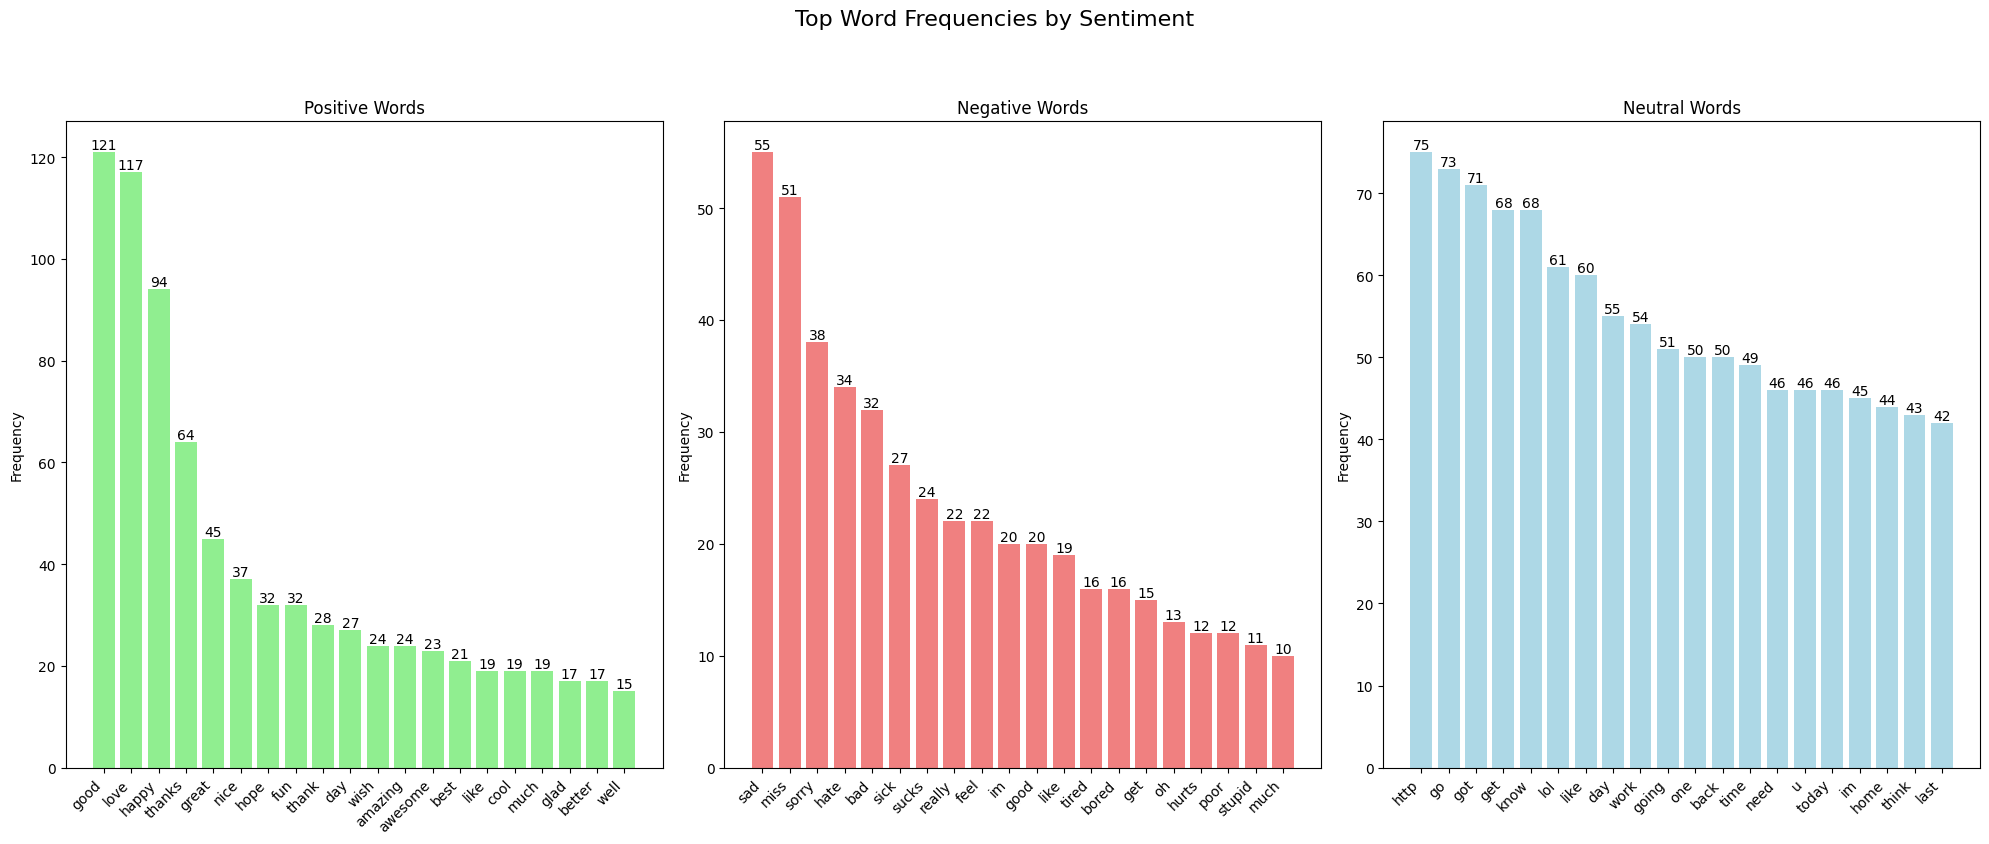

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def analyze_sentiment_words(submission_path, test_path, top_n=20):
    # Read the data
    submission_df = pd.read_csv('/kaggle/working/submission.csv')
    test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
    
    # Merge submission with test data to get sentiment labels
    analysis_df = pd.merge(
        submission_df, 
        test_df[['textID', 'sentiment', 'text']], 
        on='textID'
    )
    
    # Initialize word counters for each sentiment
    sentiment_word_counter = {
        'positive': Counter(),
        'negative': Counter(),
        'neutral': Counter()
    }
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Process each selected text
    for _, row in analysis_df.iterrows():
        # Tokenize the selected text
        words = word_tokenize(row['selected_text'].lower())
        
        # Remove stopwords and non-alphabetic tokens
        words = [word for word in words if word.isalpha() and word not in stop_words]
        
        # Add to appropriate counter
        sentiment_word_counter[row['sentiment']].update(words)
    
    # Create subplots for each sentiment
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Top Word Frequencies by Sentiment', fontsize=16, y=1.05)
    
    # Colors for each sentiment
    colors = {
        'positive': 'lightgreen',
        'negative': 'lightcoral',
        'neutral': 'lightblue'
    }
    
    # Plot for each sentiment
    for idx, sentiment in enumerate(['positive', 'negative', 'neutral']):
        # Get top N words
        top_words = dict(sentiment_word_counter[sentiment].most_common(top_n))
        
        # Create bar plot
        bars = axes[idx].bar(
            range(len(top_words)),
            list(top_words.values()),
            color=colors[sentiment]
        )
        
        # Customize plot
        axes[idx].set_title(f'{sentiment.capitalize()} Words', fontsize=12)
        axes[idx].set_xticks(range(len(top_words)))
        axes[idx].set_xticklabels(list(top_words.keys()), rotation=45, ha='right')
        axes[idx].set_ylabel('Frequency')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom'
            )
    
    plt.tight_layout()
    return sentiment_word_counter

# Example usage
word_frequencies = analyze_sentiment_words('submission.csv', 'test.csv')

# Print top 10 words for each sentiment
print("\nTop 10 words by sentiment:")
for sentiment, counter in word_frequencies.items():
    print(f"\n{sentiment.capitalize()}:")
    for word, count in counter.most_common(10):
        print(f"{word}: {count}")

## 5.2 Analysis of the results of the Improve Model (RoBERTa)

Let me analyze the results:

### 5.2.1 selected_text

The table below shows the text from test.csv and the first 20 lines of selected_text.  Looking at the results, it seems that the selected_text is being extracted from the text appropriately according to the sentiment. This RoBERTa model appears to be superior to the base model BERT. 

| textID     | text                                                      | selected_text                                           |
|------------|-----------------------------------------------------------|---------------------------------------------------------|
| f87dea47db | Last session of the day  http://twitpic.com/67ezh         | Last session of the day                                  |
| 96d74cb729 | Shanghai is also really exciting (precisely -...          | Shanghai is also really exciting                         |
| eee518ae67 | Recession hit Veronique Branquinho, she has to...         | shame!                                                  |
| 01082688c6 | happy bday!                                               | happy bday!                                             |
| 33987a8ee5 | http://twitpic.com/4w75p - I like it!!                    | I like it!!                                             |
| 726e501993 | that`s great!! weee!! visitors!                           | that`s great!!                                          |
| 261932614e | I THINK EVERYONE HATES ME ON HERE   lol                   | HATES                                                   |
| afa11da83f | soooooo wish i could, but im in school and my...          | blocked                                                 |
| e64208b4ef | and within a short time of the last clue all ...          | and within a short time of the last clue all o...       |
| 37bcad24ca | What did you get?  My day is alright.. haven`t...         | What did you get? My day is alright.. haven`t ...       |
| 24c92644a4 | My bike was put on hold...should have known th...         | argh total bummer                                       |
| 43b390b336 | I checked.  We didn`t win                                 | I checked. We didn`t win                                |
| 69d6b5d93e | .. and you`re on twitter! Did the tavern bore...          | .. and you`re on twitter! Did the tavern bore ...       |
| 5c1e0b61a1 | I`m in VA for the weekend, my youngest son tur...         | sad,                                                    |
| 504e45d9d9 | Its coming out the socket  I feel like my phon...         | loose it is...                                          |
| ae93ad52a0 | So hot today =_=  don`t like it and i hate my ...         | don`t like it and i hate my new timetable, hav...       |
| 9fce30159a | Miss you                                                  | Miss you                                                |
| 00d5195223 | Cramps . . .                                              | Cramps                                                  |
| 33f19050cf | you guys didn`t say hi or answer my questions...          | nice                                                    |
| f7718b3c23 | I`m going into a spiritual stagnentation, its ...         | I`m going into a spiritual stagnentation, its ...       |


### 5.2.1 RoBERTa Model's Kaggle Score is 0.71383
- The RoBERTa model scored 0.71383 on Kaggle. 
- This is a significant improvement on the BERT model's score of 0.50013.


### 5.2.2 Training Performance:


- The model was trained for 3 epochs across 5 folds
- Training loss consistently decreased across epochs (from ~2.2 to ~1.5)
- Validation loss remained relatively stable (around 1.6-1.7)
- Good consistency across folds with similar learning patterns


### 5.2.3 Jaccard Scores:


- Mean Jaccard score across folds: 0.7023
- Individual fold scores:

  - Fold 1: 0.7030
  - Fold 2: 0.7033
  - Fold 3: 0.7025
  - Fold 4: 0.6973
  - Fold 5: 0.7077


-  Very consistent performance across folds (low variance)


### 5.2.4 Sentiment Distribution:


- Neutral: 1430 samples (40.5%)
- Positive: 1103 samples (31.2%)
- Negative: 1001 samples (28.3%)
- Slightly imbalanced dataset with more neutral samples


### 5.2.5 Text Length Analysis:


- Mean lengths by sentiment:

  - Neutral: 64.7 characters (highest)
  - Negative: 18.1 characters
  - Positive: 15.5 characters


- Neutral texts tend to be significantly longer
- High standard deviation in all categories indicates variable length


### 5.2.6 Jaccard Score by Sentiment:


- Neutral: Mean 0.999 (best performing)
- Negative: Mean 0.326
- Positive: Mean 0.294 (most challenging)
- Neutral sentiment shows remarkably high performance
- More variance in positive/negative sentiment predictions


### 5.2.7 Length Ratios:


- Most selected texts are either very short compared to original text (ratio < 0.2) or complete matches (ratio = 1.0)
- This suggests the model is good at identifying both specific sentiment-bearing phrases and cases where the entire text is relevant

### 5.2.8 Key Insights:

- The model is very stable across folds with consistent performance
- It performs exceptionally well on neutral sentiment
- There's room for improvement in positive and negative sentiment extraction
- The model has learned to be selective in text extraction, choosing either very specific phrases or complete texts when appropriate

# 6. Conclusion
## 6.1  Improve Model (RoBERTa) Performance is better than the Base Model (BERT Model):


- Overall strong performance with a mean Jaccard score of 0.7028
- Very stable across folds (scores ranging from 0.6973 to 0.7077)
- Successfully learned to handle variable-length text selections
- Good convergence in training with consistent loss reduction


## 6.2 Sentiment-Specific Performance:


- Exceptional performance on neutral sentiment (0.999 Jaccard score)

  - Likely because neutral often requires keeping most/all of the text
  - Less subjective decision-making needed for neutral texts


- Moderate performance on negative (0.326) and positive (0.294) sentiments

  - More challenging due to need for precise phrase selection
  - Higher subjectivity in determining sentiment-bearing phrases




## 6.3 Dataset Characteristics:


- Imbalanced class distribution:

  - Neutral: 40.5%
  - Positive: 31.2%
  - Negative: 28.3%
 

- Significant variation in text lengths:

  - Neutral texts tend to be much longer (mean 64.7 characters)
  - Emotional texts (positive/negative) are shorter (15-18 characters)




## 6.4 Areas for Potential Improvement:


- Focus on improving positive and negative sentiment extraction
- Consider techniques to handle class imbalance
- Explore methods to better identify sentiment-bearing phrases in longer texts
- Investigate ways to reduce variance in emotional sentiment predictions


## 6.5 Model Strengths:


- Consistent performance across folds indicates robust learning
- Good adaptation to varying text lengths
- Strong ability to identify when full text should be retained
- Effective at extracting both short phrases and complete texts when appropriate


## 6.6 Practical Implications:


- Model is production-ready for neutral sentiment extraction
- May need additional refinement for emotional sentiment tasks
- Could be particularly useful for applications where neutral text identification is critical
- Consider ensemble or specialized models for positive/negative sentiment extraction


## 6.7 Future Recommendations:


- Collect more positive and negative samples to balance the dataset
- Experiment with different architectures for emotional sentiment extraction
- Consider sentiment-specific model tuning
- Investigate additional features or pre-processing steps to improve emotional sentiment performance